In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import re
from datetime import date
from datetime import timedelta

### Utilities functions:
* **daterange**: it divide the time in days
* **log_progress**: function that creates the progress bar for for-loops

In [2]:
def daterange(start_date, end_date): #ciclo su giorni
    for n in range(int((end_date-start_date).days)):
        yield (start_date + timedelta(n))

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


### Import data from local archive. Change it if you want to import from cloud

In [3]:
import os
import sys
start_date=date(2019,4,16)
end_date=date(2019,4,30)
# setup toolbar

sensor = 'S6.1.3'
directory = 'C:/Users/aless/Desktop/Dottorato/ST_projects/Data_installations/'
result1 = []
i = 0
for gg in log_progress([date for date in daterange(start_date,end_date)]):
    y,m,d=(gg.strftime('%Y,%m,%d')).split(",")
    start =y+'-'+ m +'-'+d
    df = pd.read_parquet(directory+'ss335-acc'+start+sensor.replace(".","")+'.parquet')
    df = df.drop(['x','y'],1)
    if i==0:
        result1 = df
        i = 1
    result1 = pd.concat([result1,df])
result1.head()

,z,ts
0,-13251,1555433969948
0,-13253,1555433969948
0,-13250,1555433969948
0,-13245,1555433969948
0,-13255,1555433969948


In [4]:
start_date=date(2019,5,21)
end_date=date(2019,5,28)
# setup toolbar


sensor = 'S6.1.3'
directory = 'C:/Users/aless/Desktop/Dottorato/ST_projects/Data_installations/'
result2 = []
i = 0
for gg in log_progress([date for date in daterange(start_date,end_date)]):
    y,m,d=(gg.strftime('%Y,%m,%d')).split(",")
    start =y+'-'+ m +'-'+d
    df = pd.read_parquet(directory+'ss335-acc'+start+sensor.replace(".","")+'.parquet')
    df = df.drop(['x','y'],1)
    if i==0:
        result2 = df
        i = 1
    result2 = pd.concat([result2,df])
result2.head()

,z,ts
0,-13342,1558398541688
0,-13354,1558398541688
0,-13354,1558398541688
0,-13313,1558398541688
0,-13295,1558398541688


In [10]:
prova = result1['z'].values[::100]
result1['z'] =prova.shape

ValueError: Length of values does not match length of index

### Figures of merits used to evaluate the reconstruction performance

In [5]:
RSNR = lambda x, xr: np.sum(x**2, axis=0)/np.sum((x - xr)**2, axis=0)
ARSNR = lambda x, xr: np.mean(RSNR(x, xr))
RSNRdB = lambda x, xr: 10*np.log10(RSNR(x, xr))
ARSNRdB = lambda x, xr: 10*np.log10(ARSNR(x, xr))

### Filtering of the dataset. Training dataset composed by the week 16-23 April 2019.

In [ ]:
import datetime as dt
dt.datetime.utcfromtimestamp(dt.datetime(2019,4,16,19,0,0).timestamp())
dt.datetime.utcfromtimestamp(1558398541688/1000)
#dt.datetime(2019,4,16,19,0,0).timestamp()
training_set = result1['z'].values[(result1['ts'].values/1000)<(dt.datetime(2019,4,23,19,0,0).timestamp())]

### Creation of a small dataset for plot, conversion to g, and RMS computing. The second half-day (average) of the training week (time series).

In [12]:
result2['z'].values.shape[0]/100/60/60/24

6.885484027777777

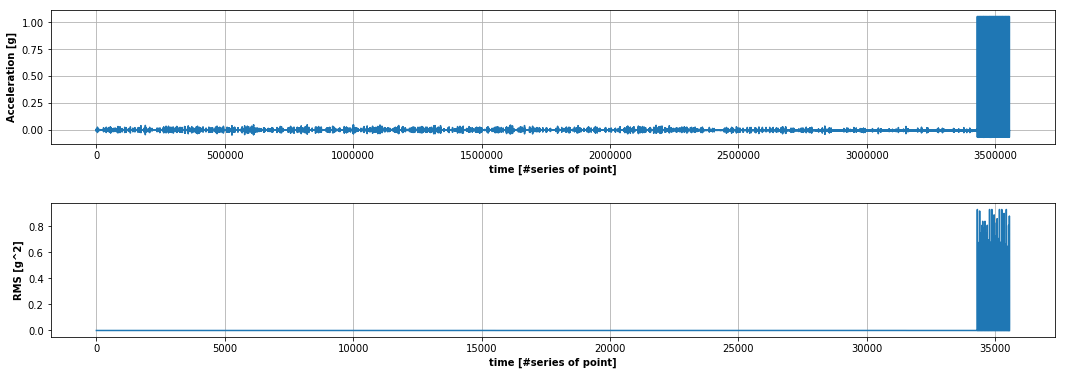

In [ ]:
plt.figure(figsize = (18,6))
plt.subplot2grid((2, 1), (0, 0), colspan=1)
#plotting half of the first day: the second half.
day = 2
conv=(1*2.5)*2**-15
plot1 = training_set[(training_set.shape[0]//14)*(day-1):(training_set.shape[0]//14)*(day)]*conv
plot1 = plot1 -np.mean(plot1)
plt.plot(plot1)
plt.grid(which = 'both', axis = 'x')
plt.grid(axis='y')
plt.ylabel('Acceleration [g]', fontsize=10, fontweight='bold')
plt.xlabel('time [#series of point]', fontsize=10, fontweight='bold')
d = 100
N = plot1.shape[0]
plt.subplot2grid((2, 1), (1, 0), colspan=1)
N0 = N//d
time_series = plot1[:N0*d]
time_series = time_series.reshape((N0,d)).T
time_series = time_series
time_series = time_series 
RMS = np.sum(time_series**2,axis=0)/d
plt.plot(RMS)
plt.grid(which = 'both', axis = 'x')
plt.ylabel('RMS [g^2]', fontsize=10, fontweight='bold')
plt.xlabel('time [#series of point]', fontsize=10, fontweight='bold')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.45)
plt.show()
#plotting the histogram
fig = plt.figure()
        # An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=RMS, bins='auto', color='C0', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel('RMS value of the interval [g^2]',fontsize=10, fontweight='bold')
plt.ylabel('Frequency of the RMS values', fontsize=10, fontweight='bold')
plt.xlim(0, 0.00005)
plt.title("Distribution of RMS 1s windows")
# Set a clean upper y-axis limit.
plt.ylim(ymax=12000)
plt.show()

### Definition of the **valid** dataset, with a predefined threshold on the RMS. Here, I selected 3 threshold (by hand), multiple can be defined.

In [19]:
# inputs 
d = 100
day = 2
threshold_mean = 0.00001
threshold_low = 0.0000004
threshold_high = 0.00005
threshold = threshold_mean
Training_dataset = training_set*conv
N = Training_dataset.shape[0]
N0 = N//d
Training_dataset = Training_dataset[:N0*d]
Training_dataset = Training_dataset.reshape((N0,d)).T
Training_dataset = Training_dataset - np.mean(Training_dataset, axis=0)
RMS_training = np.sum(Training_dataset**2,axis=0)/d
RMS_training_valid = RMS_training>threshold
new_dataset = Training_dataset[:,RMS_training_valid]
print('training set composed by {} instances'.format(Training_dataset.shape[1]))
print('total valid windows is {} '.format(np.sum(RMS_training_valid)))

training set composed by 567460 instances
total valid windows is 31772 


### Definition of the eigenvectors needed to achieve a certain amount of energy.

k = 22


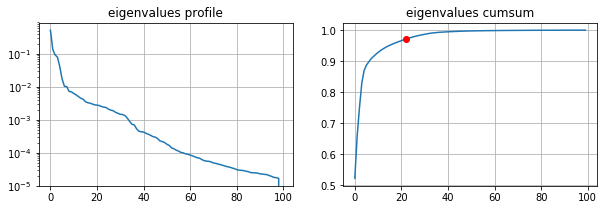

In [20]:
Cx = np.dot(new_dataset, new_dataset.T)/d
lx, Vx = np.linalg.eigh(Cx)
lx = lx[::-1]
Vx = Vx[:,::-1]
lcumsum = np.cumsum(lx/np.sum(lx))
k = np.argmax(lcumsum > 0.97)

print('k = {}'.format(k))

fig, ax = plt.subplots(1, 2, figsize=(10,3))

ax[0].plot(lx/np.sum(lx))
ax[0].set(yscale='log')
ax[0].set(title='eigenvalues profile')
ax[0].grid()

ax[1].plot(np.cumsum(lx/np.sum(lx)))
ax[1].plot(k, lcumsum[k], 'or')
ax[1].set(title='eigenvalues cumsum')
ax[1].grid()
plt.show()

 ### Compression and decompression of the signal to see the RSNR of the algorithm. 16 dB is the one expected with 0.97 energy

In [21]:
k = 22
Xrpca = np.linalg.multi_dot([Vx[:,:k], Vx[:,:k].T, new_dataset])
arsnrpca = ARSNRdB(new_dataset, Xrpca)

print('ARSNR_PCA = {:.2f}'.format(arsnrpca))

ARSNR_PCA = 15.99


### Redefinition of the function to loop on hours

In [23]:
import time
def daterange(start_date, end_date): #ciclo su giorni
    for n in range(int((end_date-start_date).days)*24):
        yield (dt.datetime.utcfromtimestamp(time.mktime(start_date.timetuple())).timestamp() + 3600*n)

### Assessing quality of reconstruction on 1 week before intervention, hour x hour.

In [24]:
sumASNR = 0
start_date=date(2019,4,23)
end_date=date(2019,4,30)
arsnrpca_valid = []
date_valid = []
for d_index in log_progress([date for date in daterange(start_date,end_date)]):
    start = result1['ts'].values/1000>d_index
    end = result1['ts'].values/1000<(d_index+60*60)
    Test_pre = result1['z'].values[ start & end]*conv
    if Test_pre.shape[0]>0:
        N = Test_pre.shape[0]
        N0 = N//d
        Test_pre = Test_pre[:N0*d]
        Test_pre = Test_pre.reshape((N0,d)).T
        Test_pre = Test_pre - np.mean(Test_pre, axis=0)
        RMS_test = np.sum(Test_pre**2,axis=0)/d
        RMS_test_valid = RMS_test>threshold
        Test_pre = Test_pre[:,RMS_test_valid]
        Xrpca = np.linalg.multi_dot([Vx[:,:k], Vx[:,:k].T, Test_pre])
        arsnrpca = ARSNRdB(Test_pre, Xrpca)
        arsnrpca_valid.append(arsnrpca)
        date_valid.append(d_index)


In [28]:
np.asarray(arsnrpca_valid).shape

(154,)

### Assessing quality of reconstruction on 1 week after intervention, hour x hour.

In [25]:
sumASNR = 0
start_date=date(2019,5,21)
end_date=date(2019,5,28)
arsnrpca_valid2 = []
date_valid2 = []
for d_index in log_progress([date for date in daterange(start_date,end_date)]):
    start = result2['ts'].values/1000>d_index
    end = result2['ts'].values/1000<(d_index+60*60)
    Test_pre = result2['z'].values[ start & end]*conv
    if Test_pre.shape[0]>0:
        N = Test_pre.shape[0]
        N0 = N//d
        Test_pre = Test_pre[:N0*d]
        Test_pre = Test_pre.reshape((N0,d)).T
        Test_pre = Test_pre - np.mean(Test_pre, axis=0)
        RMS_test = np.sum(Test_pre**2,axis=0)/d
        RMS_test_valid = RMS_test>threshold
        Test_pre = Test_pre[:,RMS_test_valid]
        Xrpca = np.linalg.multi_dot([Vx[:,:k], Vx[:,:k].T, Test_pre])
        arsnrpca = ARSNRdB(Test_pre, Xrpca)
        arsnrpca_valid2.append(arsnrpca)
        date_valid2.append(d_index)


C:\Users\aless\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\aless\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


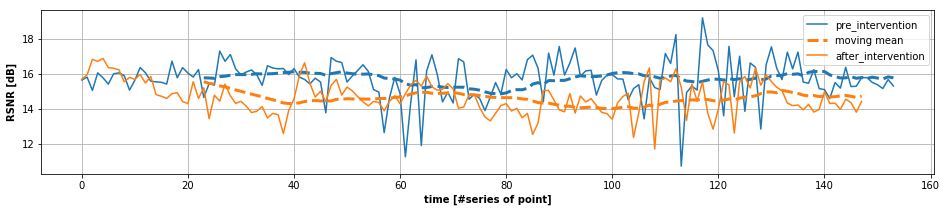

In [32]:
plt.figure(figsize=(16,3))
arsnrpca_valid = np.asarray(arsnrpca_valid)[~np.isnan(np.asarray(arsnrpca_valid))]
plt.plot(np.arange(arsnrpca_valid.shape[0]),arsnrpca_valid, color = 'C0', label = 'pre_intervention')
N = 24
cumsum, moving_aves = [0], []

for i, x in enumerate(arsnrpca_valid, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

plt.plot(np.arange(23,arsnrpca_valid.shape[0]),moving_aves,'--', color = 'C0', linewidth = 3)   

N = 24
arsnrpca_valid2 = np.asarray(arsnrpca_valid2)[~np.isnan(np.asarray(arsnrpca_valid2))]
cumsum, moving_aves = [0], []
for i, x in enumerate(arsnrpca_valid2, 1):
    if np.isnan(x)==0:
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
plt.plot(np.arange(23,arsnrpca_valid2.shape[0]),moving_aves,'--', linewidth = 3, color = 'C1', label = 'moving mean')   

plt.plot(np.arange(arsnrpca_valid2.shape[0]),np.asarray(arsnrpca_valid2), color = 'C1', label = 'after_intervention')
plt.grid(which = 'both', axis = 'both')
plt.ylabel('RSNR [dB]', fontsize=10, fontweight='bold')
plt.xlabel('time [#series of point]', fontsize=10, fontweight='bold')
plt.legend()

In [42]:
np.asarray(date_valid).shape

(303,)